# MPO utilities

In [1]:
from MPO_utilities import *

# One-hot MPO projector

In [2]:
import numpy as np
import quimb as qu
import quimb.tensor as qtn

# compat patch (matches your setup)
if not hasattr(qu, "transpose"):
    qu.transpose = np.transpose


def mpo_one_hot_projector(q, *, upper_ind_id="k{}", lower_ind_id="b{}"):
    """
    Diagonal MPO on q qubits projecting onto the one-hot subspace:
      P = sum_{m=0}^{q-1} |0...010...0><0...010...0|
    i.e. exactly one '1' among the q qubits.

    Returns: quimb.tensor.MatrixProductOperator
    Bond dimension: q+1 (counts number of 1s seen so far, capped at 2 then killed)
    """
    I = np.eye(2, dtype=complex)
    P0 = np.array([[1, 0], [0, 0]], dtype=complex)  # |0><0|
    P1 = np.array([[0, 0], [0, 1]], dtype=complex)  # |1><1|

    # states: c in {0, 1, 2} meaning "seen c ones so far (2 = >=2 / dead)"
    D = 3

    arrs = []
    for s in range(q):
        if q == 1:
            # one-hot on 1 qubit means exactly |1>
            W = np.zeros((1, 1, 2, 2), dtype=complex)
            W[0, 0] = P1
            arrs.append(W.reshape(1, 2, 2))  # boundary
            break

        if s == 0:
            W = np.zeros((1, D, 2, 2), dtype=complex)
            # if qubit=0 keep count, if qubit=1 increment
            W[0, 0] = P0          # 0 -> stay at 0
            W[0, 1] = P1          # 1 -> go to 1
            arrs.append(W[0])     # (Dr,u,d) == "rud"
        elif s == q - 1:
            W = np.zeros((D, 1, 2, 2), dtype=complex)
            # accept only paths that end with total count == 1
            W[0, 0] = P1          # from 0 with last=1 -> total 1
            W[1, 0] = P0          # from 1 with last=0 -> total 1
            W[2, 0] = 0.0         # dead stays dead
            arrs.append(W[:, 0])  # (Dl,u,d) == "lud"
        else:
            W = np.zeros((D, D, 2, 2), dtype=complex)

            # on a 0: keep count (including dead)
            W[0, 0] = P0
            W[1, 1] = P0
            W[2, 2] = P0

            # on a 1: increment count; 1->dead if already saw one
            W[0, 1] = P1
            W[1, 2] = P1
            W[2, 2] = P1  # dead stays dead

            arrs.append(W)  # (Dl,Dr,u,d) == "lrud"

    return qtn.MatrixProductOperator(
        [np.asarray(A, dtype=complex) for A in arrs],
        sites=range(q),
        shape="lrud",
        upper_ind_id=upper_ind_id,
        lower_ind_id=lower_ind_id,
    )

def mpo_prod_one_hot_projector(n, q, *, upper_ind_id="k{}", lower_ind_id="b{}"):
    P = mpo_one_hot_projector(q, upper_ind_id=upper_ind_id, lower_ind_id=lower_ind_id)
    return kronMPOs([P]*n)


# ----------------
# quick sanity check (small q)
# ----------------
if __name__ == "__main__":
    n = 2
    q = 3
    P = mpo_prod_one_hot_projector(n, q)
    P.show()
    Pd = P.to_dense()

    print(np.nonzero(np.diag(np.round(np.real(Pd), 1))))

│3│3│1│3│3│
●─●─●─●─●─●
│ │ │ │ │ │
(array([ 9, 10, 12, 17, 18, 20, 33, 34, 36]),)


# Trotter MPOs

In [3]:
import numpy as np
import quimb as qu
import quimb.tensor as qtn

# ---- compatibility patch for some quimb/autoray versions ----
if not hasattr(qu, "transpose"):
    qu.transpose = np.transpose


def _as_np(x):
    return np.asarray(x, dtype=complex)

def exp_i_theta_Z(theta):
    return _as_np([
        [np.exp(1j* theta), 0.0],
        [0.0,  np.exp(-1j* theta)],
    ])


def exp_i_theta_xx_yy(theta):
    c = np.cos(2.0 * theta)
    s = 1j * np.sin(2.0 * theta)
    return _as_np([
        [1.0, 0.0, 0.0, 0.0],
        [0.0,   c,   s, 0.0],
        [0.0,   s,   c, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ])
    
def exp_i_theta_ZZ(theta):
    return _as_np([
        [np.exp(1j* theta), 0.0, 0.0, 0.0],
        [0.0, np.exp(-1j* theta), 0.0, 0.0],
        [0.0, 0.0, np.exp(-1j* theta), 0.0],
        [0.0, 0.0, 0.0, np.exp(1j* theta)],
    ])


P0 = _as_np([[1, 0],
             [0, 0]])
P1 = _as_np([[0, 0],
             [0, 1]])


def mpo_identity_arrays(L, d=2):
    """Identity MPO with *rank-3 boundaries*: left is (r,u,d), right is (l,u,d)."""
    I = _as_np(np.eye(d))
    arrs = []
    for s in range(L):
        if s == 0:
            arrs.append(I.reshape(1, d, d).copy())      # (Dr=1, u, d) == "rud"
        elif s == L - 1:
            arrs.append(I.reshape(1, d, d).copy())      # (Dl=1, u, d) == "lud"
        else:
            arrs.append(I.reshape(1, 1, d, d).copy())   # (Dl, Dr, u, d) == "lrud"
    return arrs


def mpo_from_arrays(arrs, *, upper_ind_id="k{}", lower_ind_id="b{}"):
    """
    Build MPO from a mix of:
      left boundary:  (Dr, u, d)
      middle:         (Dl, Dr, u, d)
      right boundary: (Dl, u, d)
    with shape='lrud' telling quimb what order these correspond to.
    """
    L = len(arrs)
    arrs = [_as_np(A) for A in arrs]
    return qtn.MatrixProductOperator(
        arrs,
        sites=range(L),
        shape="lrud",
        upper_ind_id=upper_ind_id,
        lower_ind_id=lower_ind_id,
    )


def _set_site_tensor_with_boundary(arrs, s, W):
    """
    Put a rank-4 site tensor W[Dl,Dr,u,d] into arrs[s], but if s is a boundary,
    drop the missing bond index to make it rank-3 as desired.
    """
    W = _as_np(W)
    if s == 0:
        # want (Dr,u,d) -> drop Dl (assumed 1)
        if W.shape[0] != 1:
            raise ValueError("Left boundary expects Dl=1.")
        arrs[s] = W[0, :, :, :]          # (Dr,u,d)
    elif s == len(arrs) - 1:
        # want (Dl,u,d) -> drop Dr (assumed 1)
        if W.shape[1] != 1:
            raise ValueError("Right boundary expects Dr=1.")
        arrs[s] = W[:, 0, :, :]          # (Dl,u,d)
    else:
        arrs[s] = W                      # (Dl,Dr,u,d)

def mpo_product_unitaries(U_list, *, upper_ind_id="k{}", lower_ind_id="b{}"):
    """
    Build a rank-1 MPO (bond dim = 1) representing ⊗_i U_list[i].

    Parameters
    ----------
    U_list : list of (2,2) arrays
        One-qubit unitaries (or any 2x2 operators) for each site, in site order.
    """
    L = len(U_list)
    arrs = []

    for i, U in enumerate(U_list):
        U = np.asarray(U, dtype=complex)
        if U.shape != (2, 2):
            raise ValueError(f"U_list[{i}] must have shape (2,2), got {U.shape}.")

        if L == 1:
            # single-site MPO can just be rank-2, but we keep boundary convention consistent:
            arrs.append(U.reshape(1, 2, 2))          # "rud" (Dr,u,d)
        elif i == 0:
            arrs.append(U.reshape(1, 2, 2))          # left boundary: (Dr,u,d) == "rud"
        elif i == L - 1:
            arrs.append(U.reshape(1, 2, 2))          # right boundary: (Dl,u,d) == "lud"
        else:
            arrs.append(U.reshape(1, 1, 2, 2))       # middle: (Dl,Dr,u,d) == "lrud"

    return qtn.MatrixProductOperator(
        [np.asarray(A, dtype=complex) for A in arrs],
        sites=range(L),
        shape="lrud",
        upper_ind_id=upper_ind_id,
        lower_ind_id=lower_ind_id,
    )

def mpo_two_site_gate_nonlocal(L, j, k, U2, *, svd_cutoff=1e-12):
    if j == k:
        raise ValueError("Need two distinct sites.")
    if j > k:
        j, k = k, j

    d = 2
    U2 = _as_np(U2)

    # U2 -> (out_j,out_k,in_j,in_k) then to (out_j,in_j) x (out_k,in_k)
    U = U2.reshape(d, d, d, d)
    U = np.transpose(U, (0, 2, 1, 3))
    M = U.reshape(d * d, d * d)

    Uu, Ss, Vh = np.linalg.svd(M, full_matrices=False)
    keep = np.where(Ss > svd_cutoff)[0]
    Uu = Uu[:, keep]
    Ss = Ss[keep]
    Vh = Vh[keep, :]

    r = len(Ss)
    sqrtS = np.sqrt(Ss)

    Aops = [(Uu[:, a] * sqrtS[a]).reshape(d, d) for a in range(r)]
    Bops = [(Vh[a, :] * sqrtS[a]).reshape(d, d) for a in range(r)]

    arrs = mpo_identity_arrays(L, d=d)
    I = _as_np(np.eye(d))

    # site j core tensor: (Dl=1, Dr=r, u, d)
    Aj = np.zeros((1, r, d, d), dtype=complex)
    for a in range(r):
        Aj[0, a, :, :] = Aops[a]
    _set_site_tensor_with_boundary(arrs, j, Aj)

    # middle propagation tensors: (Dl=r, Dr=r, u, d)
    for s in range(j + 1, k):
        W = np.zeros((r, r, d, d), dtype=complex)
        for a in range(r):
            W[a, a, :, :] = I
        # NOTE: if s is boundary (can only happen if L=2, but then no middle), safe anyway
        _set_site_tensor_with_boundary(arrs, s, W)

    # site k core tensor: (Dl=r, Dr=1, u, d)
    Bk = np.zeros((r, 1, d, d), dtype=complex)
    for a in range(r):
        Bk[a, 0, :, :] = Bops[a]
    _set_site_tensor_with_boundary(arrs, k, Bk)

    return mpo_from_arrays(arrs)

def mpo_XY_pairs(L, pairs, theta, *, max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    U2 = exp_i_theta_xx_yy(theta)
    mpo = mpo_from_arrays(mpo_identity_arrays(L))
    for (j, k) in pairs:
        mpo_jk = mpo_two_site_gate_nonlocal(L, j, k, U2, svd_cutoff=svd_cutoff)
        mpo = mpo_jk.apply(mpo, compress=True, max_bond=max_bond, cutoff=cutoff)
    return mpo

def mpo_rand_ZZ_pairs(L, pairs, W, *, max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    mpo = mpo_from_arrays(mpo_identity_arrays(L))
    for (j, k) in pairs:
        theta = W*np.pi*(2*np.random.random()-1.)
        U2 = exp_i_theta_ZZ(theta)
        mpo_jk = mpo_two_site_gate_nonlocal(L, j, k, U2, svd_cutoff=svd_cutoff)
        mpo = mpo_jk.apply(mpo, compress=True, max_bond=max_bond, cutoff=cutoff)
    return mpo

def mpo_rand_Z(L, W):
    U_list = []
    for _ in range(L):
        theta = W*np.pi*(2*np.random.random()-1.)
        U1 = exp_i_theta_Z(theta)
        U_list.append(U1)
    return mpo_product_unitaries(U_list)

def multi_controlled_pairs_mpo(L, controls, pairs, theta, *,
                               max_bond=None, cutoff=1e-12, svd_cutoff=1e-12):
    """
    MPO for:
      (I - Π_c P1(c)) ⊗ I   +   (Π_c P1(c)) ⊗ U_pairs
    equivalently:
      Π_c P0(c) ⊗ I + Π_c P1(c) ⊗ U_pairs  only if there is exactly one control,
    but for multiple controls the 'else' branch should be identity whenever any control is 0.

    Here we implement:
      mpo = mpo_else + mpo_then
    where:
      mpo_then = (Π_c P1(c)) ⊗ U_pairs
      mpo_else = I - (Π_c P1(c)) ⊗ I
    so total is identity unless all controls are 1.
    """
    controls = tuple(controls)
    if len(controls) == 0:
        # no controls: just return U_pairs
        return mpo_XY_pairs(L, pairs, theta, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

    # validate controls
    if len(set(controls)) != len(controls):
        raise ValueError("Duplicate control indices.")
    for c in controls:
        if not (0 <= c < L):
            raise ValueError(f"Control index {c} outside [0, L).")

    # validate pairs (disjoint + don't touch controls)
    used = set()
    for (j, k) in pairs:
        if j == k:
            raise ValueError(f"Pair {(j, k)} has j==k.")
        if j in controls or k in controls:
            raise ValueError(f"Control appears in pair {(j, k)}.")
        if j in used or k in used:
            raise ValueError("Pairs overlap (share a site).")
        used.add(j); used.add(k)

    # U_pairs
    mpoU = mpo_XY_pairs(L, pairs, theta, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

    # Π_c P1(c) as an MPO (diagonal projectors placed locally)
    arrP1 = mpo_identity_arrays(L)
    for c in controls:
        W = P1.reshape(1, 1, 2, 2)
        _set_site_tensor_with_boundary(arrP1, c, W)
    mpoAll1 = mpo_from_arrays(arrP1)

    # THEN branch: (Π_c P1(c)) ⊗ U_pairs
    mpo_then = mpoAll1.apply(mpoU, max_bond=max_bond, cutoff=cutoff)

    # ELSE branch: I - (Π_c P1(c)) ⊗ I
    # Build I as an MPO:
    mpoI = mpo_from_arrays(mpo_identity_arrays(L))
    # The (Π_c P1(c)) ⊗ I is just mpoAll1 itself (since other sites are identity ops)
    mpo_else = mpoI - mpoAll1

    mpo = mpo_else + mpo_then
    mpo.compress(max_bond=max_bond, cutoff=cutoff)
    return mpo

def MCXY_trotter_step_mpos(D, n, q, dt, max_bond=None, cutoff=1e-10, svd_cutoff=1e-14):
    Q = n * q
    
    even_pairs = [(i, i+1) for i in range(0, q-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, q-1, 2)]
    
    even_mpos = [mpo_XY_pairs(Q, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    odd_mpos = [mpo_XY_pairs(Q, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    
    if q % 2 == 0:
        for l in range(1, n):
            even_controls = [q*lp for lp in range(l-1)] + [q*l - 1]
            odd_controls = [q*lp for lp in range(l)] 
            
            even_pairs = [(q*l+i, q*l+i+1) for i in range(0, q-1, 2)]
            odd_pairs = [(q*l+i, q*l+i+1) for i in range(1, q-1, 2)]

            even_mpo = multi_controlled_pairs_mpo(Q, even_controls, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)
            odd_mpo = multi_controlled_pairs_mpo(Q, odd_controls, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

            even_mpo_kron = [even_mpo] * D
            odd_mpo_kron = [odd_mpo] * D
            
            even_mpos.append(kronMPOs(even_mpo_kron))
            odd_mpos.append(kronMPOs(odd_mpo_kron))
    
    elif q % 2 == 1:
        for l in range(1, n):
            even_controls = [q*lp-1 for lp in range(1, l+1)]
            odd_controls = [q*lp for lp in range(l)] 
            
            even_pairs = [(q*l+i, q*l+i+1) for i in range(0, q-1, 2)]
            odd_pairs = [(q*l+i, q*l+i+1) for i in range(1, q-1, 2)]
            
            even_mpo = multi_controlled_pairs_mpo(Q, even_controls, even_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)
            odd_mpo = multi_controlled_pairs_mpo(Q, odd_controls, odd_pairs, dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)

            even_mpo_kron = [even_mpo] * D
            odd_mpo_kron = [odd_mpo] * D
            
            even_mpos.append(kronMPOs(even_mpo_kron))
            odd_mpos.append(kronMPOs(odd_mpo_kron))
    
    return even_mpos, odd_mpos

# W = disorder strength
def randZZ_trotter_step_mpos(D, n, q, dt, W, max_bond=None, cutoff=1e-10, svd_cutoff=1e-14):
    DQ = D * n * q
    
    even_pairs = [(i, i+1) for i in range(0, DQ-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, DQ-1, 2)]
    
    even_mpos = [mpo_rand_ZZ_pairs(DQ, even_pairs, W*dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)] 
    odd_mpos = [mpo_rand_ZZ_pairs(DQ, odd_pairs, W*dt, max_bond=max_bond, cutoff=cutoff, svd_cutoff=svd_cutoff)]
    
    return even_mpos, odd_mpos

# W = disorder strength
def randZ_trotter_step_mpos(D, n, q, dt, W):
    DQ = D * n * q
    return [mpo_rand_Z(DQ, W*dt)]

# W = disorder strength
def trotter_evolution(init_mps, D, n, q, dt, W, n_steps, disorder_type="Z",
                      max_bond=None, cutoff=1e-10, svd_cutoff=1e-14, fidelity_type="one_hot"):
    """
    Yield the MPS after each full Trotter step.
    First yield is the initial state.
    """
    XY_even_mpos, XY_odd_mpos = MCXY_trotter_step_mpos(
        D, n, q, dt,
        max_bond=None,
        cutoff=cutoff,
        svd_cutoff=svd_cutoff,
    )

    if disorder_type == "Z":
        Z_mpos = randZ_trotter_step_mpos(D, n, q, dt, W)
        trotter_mpos = XY_even_mpos + XY_odd_mpos + Z_mpos

    elif disorder_type == "ZZ":
        ZZ_even_mpos, ZZ_odd_mpos = randZZ_trotter_step_mpos(
            D, n, q, dt, W,
            max_bond=None,
            cutoff=cutoff,
            svd_cutoff=svd_cutoff,)
        trotter_mpos = XY_even_mpos + ZZ_even_mpos + XY_odd_mpos + ZZ_odd_mpos

    
    if fidelity_type == "one_hot":
        proj_mpo = mpo_prod_one_hot_projector(D*n, q)
        fidelity_fn = lambda mps1, mps2: np.abs(mps1.H @ (proj_mpo.apply(mps2)))
    elif fidelity_type == "all":
        fidelity_fn = lambda mps1, mps2: np.abs(mps1.H @ mps2)

    cur_mps = init_mps
    yield (cur_mps, 1.0)   # t = 0

    for _ in range(n_steps):
        perfect_mps = cur_mps.copy()
        for mpo in trotter_mpos:
            perfect_mps = mpo.apply(
                perfect_mps,
                compress=False
            )
        perfect_mps.normalize()
        
        new_mps = cur_mps.copy()
        for mpo in trotter_mpos:
            new_mps = mpo.apply(
                new_mps,
                compress=True,
                max_bond=max_bond,
                cutoff=cutoff,
            )
        new_mps.normalize()
        
        cur_mps = new_mps
        yield (cur_mps, fidelity_fn(perfect_mps, cur_mps))


if __name__ == "__main__":
    q = 4
    n = 2
    dt = 0.5
    W = 1
    n_steps = 50

    '''
    init_bitstring = ["0"]*(q*n)
    init_bitstring[0] = '1'
    init_bitstring[q] = '1'
    init_bitstring = "".join(init_bitstring)
    print(init_bitstring)
    init_mps = qtn.MPS_computational_state(init_bitstring)
    
    for mps in trotter_evolution(init_mps, n, q, dt, W, n_steps):
        mps.show()
    '''

# One-hot basis

In [11]:
import numpy as np
from itertools import product

def product_rightmost_outer(*iterables):
    return [
        tuple(reversed(t))
        for t in product(*reversed(iterables))
    ]

def reflected_qary_gray_digits(n, q):
    """Reflected q-ary Gray code on n digits (MSD changes slowest)."""
    if n < 0 or q <= 0:
        raise ValueError("Need n>=0, q>0.")
    if n == 0:
        return [()]
    prev = reflected_qary_gray_digits(n - 1, q)
    out = []
    for a in range(q):
        block = prev if (a % 2 == 0) else prev[::-1]
        out.extend((a,) + t for t in block)
    return out


def one_hot_bounce_bitstrings(D, n, q, as_str=True, dtype=np.int8):
    """
    Now: the *first* register is the fastest-changing one.
    """
    digits_list = reflected_qary_gray_digits(n, q)

    if as_str:
        one_hot_bitstrings = []
        for digits in digits_list:
            # ---- KEY FIX: reverse digit order when mapping to registers ----
            digits = digits[::-1]
            chunks = []
            for d in digits:
                reg = ['0'] * q
                reg[d] = '1'
                chunks.append(''.join(reg))
            one_hot_bitstrings.append(''.join(chunks))
        
        one_hot_D_copies = [one_hot_bitstrings]*D
        one_hot_D_bitstrings = []
        for s in product_rightmost_outer(*one_hot_D_copies):
            one_hot_D_bitstrings.append("".join(s))
        return one_hot_D_bitstrings

    '''
    one_hot_basis = np.zeros((len(digits_list), n * q), dtype=dtype)
    for row, digits in enumerate(digits_list):
        digits = digits[::-1]  # ---- KEY FIX ----
        for r, d in enumerate(digits):
            one_hot_basis[row, r * q + d] = 1
    
    one_hot_D_copies = [one_hot_basis]*D
    out = []
    for s in product_rightmost_outer(*one_hot_D_copies):
        out.append("".join(s))
    return out
    '''

def mps_overlap_profile(mps, bs):
    vals = []
    for b in bs:
        b_mps = qtn.MPS_computational_state(b)
        vals.append(mps @ b_mps)
    return vals

# Save Trotter MPSs

In [21]:
from pathlib import Path

## one-hot center_delta

In [21]:
# initial state = a delta state in the center

D = 1
n = 2
q = 8
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0
instance=0

'''
# folder, important to record
folder=f"MPS/one_hot/D={D}/n={n}/q={q}/dt={dt}/n_steps={n_steps}/max_bond={max_bond}/W={0.0}/init_state_center_delta/instance_{instance}"
Path(folder).mkdir(parents=True, exist_ok=True)

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
qu.save_to_disk(init_mps, folder+"/step=0.mps")

for step, mps in enumerate(trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None), start=1):
    qu.save_to_disk(mps, folder+f"/step={step}.mps")
'''

'\n# folder, important to record\nfolder=f"MPS/one_hot/D={D}/n={n}/q={q}/dt={dt}/n_steps={n_steps}/max_bond={max_bond}/W={0.0}/init_state_center_delta/instance_{instance}"\nPath(folder).mkdir(parents=True, exist_ok=True)\n\nbs = one_hot_bounce_bitstrings(n, q, as_str=True)\ninit_mps = qtn.MPS_computational_state(bs[q**n//2])\nqu.save_to_disk(init_mps, folder+"/step=0.mps")\n\nfor step, mps in enumerate(trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=None), start=1):\n    qu.save_to_disk(mps, folder+f"/step={step}.mps")\n'

# Plot fidelities

## one-hot center_delta

In [33]:
D = 1
n = 2
q = 16
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0

fidelities_1 = []

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
for mps, fidelity in trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=4):
    mps.show()
    print(fidelity)
    fidelities_1.append(fidelity)

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000002
 2 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │

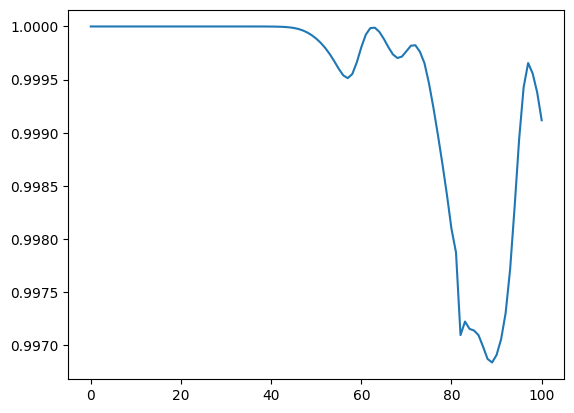

In [34]:
import matplotlib.pyplot as plt
plt.plot(fidelities_1)

## Binary

In [35]:
D = 1
n = 8
q = 2
dt = 0.1
n_steps = 100
max_bond = None
W = 0.0

fidelities_2 = []

bs = one_hot_bounce_bitstrings(n, q, as_str=True)
init_mps = qtn.MPS_computational_state(bs[q**n//2])
for mps, fidelity in trotter_evolution(init_mps, n, q, dt, W, n_steps, max_bond=4):
    mps.show()
    print(fidelity)
    fidelities_2.append(fidelity)

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
>─>─>─>─>─>─>─>─>─>─>─>─>─>─>─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0
 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000007
 2 2 4 3 3 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999999999989
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
1.0000000000000004
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.999999999997055
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999998260014
 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999968019848
 2 2 4 4 4 3 3 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
0.9999999684701146
 2 2 4 4 4 3 3 2 2 2 2 2 2 2 2 
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


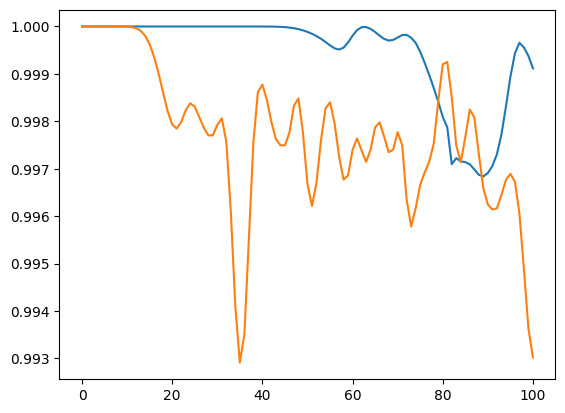

In [37]:
import matplotlib.pyplot as plt
plt.plot(fidelities_1)
plt.plot(fidelities_2)

# Plot Trotter

## Make bond_dim_profile and GIF

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio.v2 as imageio

def make_bond_dim_profile_and_gif_from_mps(mps_iter, mps_fn, *, fps=10):
    frames = []
    bond_dim_profile = []

    fig, ax = plt.subplots()
    line, = ax.plot([], [])
    ax.set_xlabel("index")
    ax.set_ylabel("value")

    for t, mps in enumerate(mps_iter):
        
        bond_sizes = mps.bond_sizes()
        bond_dim_profile.append(bond_sizes)
        
        y = np.asarray(mps_fn(mps), dtype=float)
        x = np.arange(len(y))

        line.set_data(x, y)
        ax.set_xlim(0, len(y) - 1 if len(y) else 1)
        ax.set_ylim(-1, 1)
        ax.set_title(f"t = {t}, {bond_sizes}")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)
        frames.append(img.copy())

    plt.close(fig)

    # write to bytes instead of disk
    import io
    buf = io.BytesIO()
    imageio.mimsave(buf, frames, format="GIF", duration=1.0/fps)
    buf.seek(0)

    return bond_dim_profile, Image(data=buf.read(), format="gif")


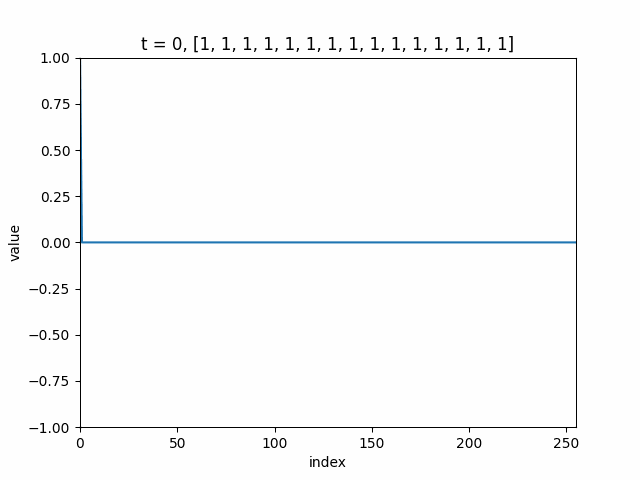

In [17]:
D_1 = 2
n_1 = 2
q_1 = 4
dt_1 = 0.1
W_1 = 0.0
n_steps_1 = 50
max_bond_1 = None

bs_1 = one_hot_bounce_bitstrings(D_1, n_1, q_1, as_str=True)
init_mps_1 = qtn.MPS_computational_state(bs_1[0])
mps_fn_1 = lambda mps: np.real(mps_overlap_profile(mps, bs_1))

mps_iter_1 = []
fidelities_1 = []
for mps, fidelity in trotter_evolution(init_mps_1, D_1, n_1, q_1, dt_1, W_1, n_steps_1, max_bond=max_bond_1):
    mps_iter_1.append(mps)
    fidelities_1.append(fidelity)

bond_dim_profile_1, gif_1 = make_bond_dim_profile_and_gif_from_mps(mps_iter_1, 
                                                                mps_fn_1,
                                                                fps = 10)

#for t, bd in enumerate(bond_dim_profile_2):
#    print(f"t = {t}:", bd)
display(gif_1)

In [ ]:
n_2 = 4
q_2 = 2
dt_2 = 0.1
W_2 = W_1 * np.sqrt(n_1/n_2)
n_steps_2 = 500
max_bond_2 = 8

bs_2 = one_hot_bounce_bitstrings(n_2, q_2, as_str=True)
init_mps_2 = qtn.MPS_computational_state(bs_2[q_2**n_2//2])
mps_fn_2 = lambda mps: np.real(mps_overlap_profile(mps, bs_2))

mps_iter_2 = []
fidelities_2 = []
for mps, fidelity in trotter_evolution(init_mps_2, n_2, q_2, dt_2, W_2, n_steps_2, max_bond=max_bond_2):
    mps_iter_2.append(mps)
    fidelities_2.append(fidelity)

bond_dim_profile_2, gif_2 = make_bond_dim_profile_and_gif_from_mps(mps_iter_2, 
                                                               mps_fn_2,
                                                               fps = 10)
#for t, bd in enumerate(bond_dim_profile_2):
#    print(f"t = {t}:", bd)

1.0000000000000002
0.9999999999999984
0.9999999999999996
0.9999999999970541
0.9999999999999994
0.9999999999999973
0.9999999999998732
0.9999999999980314
0.9999999999815987
0.9999999999956857
0.9999999999670512
0.9999999999997152
0.9999999999996534
0.9999999999996017
0.9999999999995075
0.9999999999988904
0.9999999999926199
0.9999999999572946
0.9999999999093082
0.9999999999583056
0.9999999999995415
0.9999999999997953
0.9999999999995461
0.9999999999989004
0.9999999999969678
0.9999999999910295
0.9999999999739747
0.9999999999293233
0.999999999954778
0.9999999999994287
0.9999999999993173
0.9999999999988108
0.9999999999971252
0.9999999999919651
0.9999999999771366
0.9999999999947703
0.9999999999885083
0.9999999999718248
0.9999999999999726
0.9999999999999719
0.9999999999998981
0.999999999999723
0.9999999999993754
0.9999999999986429
0.9999999999970277
0.9999999999936444
0.9999999999871209
0.9999999999748698
0.9999999999501659
0.9999999999909555
0.999999999982915
0.9999999999717707
0.9999999999527

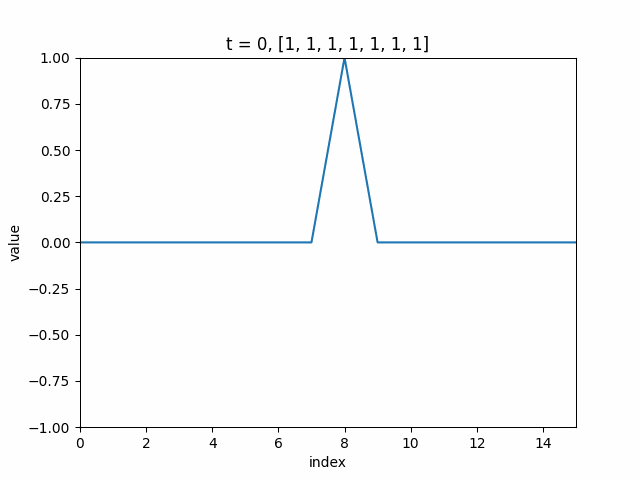

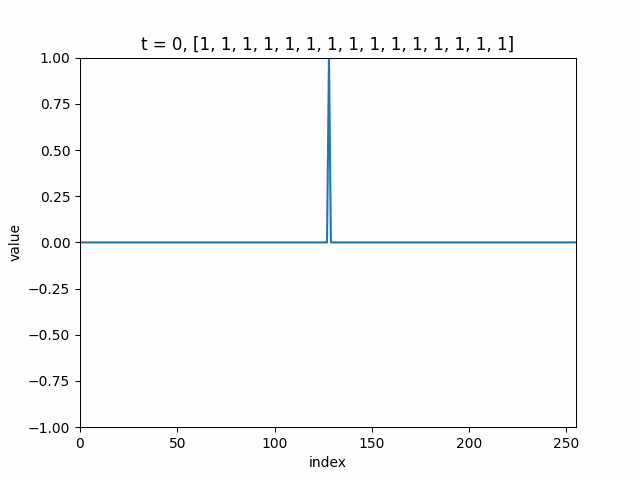

(None, None)

In [151]:
display(gif_1), display(gif_2)

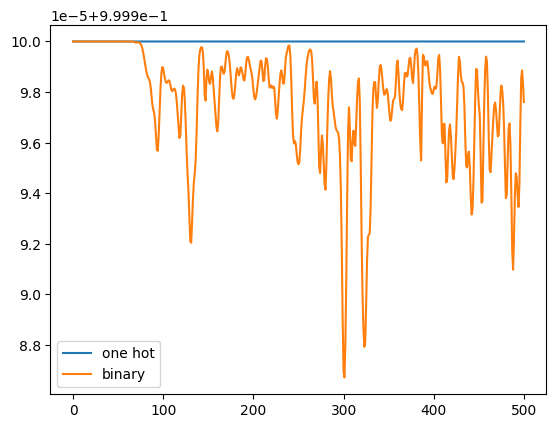

In [145]:
plt.plot(fidelities_1, label="one hot")
plt.plot(fidelities_2, label="binary")
plt.legend()
plt.show()